In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [67]:
from agents.ucb_like.cusum import CUSUMUCBAgent
from agents.ucb_like.gp_ucb import GPUCBAgent
from agents.ucb_like.sliding_window import SWUCBAgent
from environments.non_stationary import NonStationaryPricingEnv
from environments.multi_product import MultiProductPricingEnv
from utils.rbf_gaussian_process import RBFGaussianProcess

## Non-stationary pricing environment

### Parameter definition

In [68]:
# Utility function
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

In [117]:
# Parameters definition
max_price = 20
min_price = 10
cost = min_price # I set the cost to min price because that is the worst case for the seller (0 profit on a sale)

T = 10000 # number of rounds
daily_customers = 100

K = 100 # discretization intervals

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 100 different prices between 10 and 20

In [118]:
conversion_probabilities = [
    lambda p: 1-p/max_price,  # linear demand curve
    #lambda p: 1-np.exp(-p/max_price),  # exponential demand curve
    #lambda p: 1/(1+np.exp(-p/max_price)),  # logistic demand curve
    lambda p: 1 / (1 + np.log(p - min_price + 1)),  # logarithmic demand curve
    lambda p: 1 / (1 + np.sqrt(p - min_price)),  # square root demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 2)),  # square demand curve
    lambda p: 1 / (1 + np.power(p - min_price, 3)),  # cubic demand curve
    #lambda p: 1 / (1 + np.exp(0.1 * (p - (max_price + min_price) / 2))),  # sigmoid demand curve
    #lambda p: min_price / p,  # inverse demand curve
    #lambda p: np.sin(p/max_price)  # sine demand curve
]

In [119]:
mu = [[conversion_probabilities[i]]*(T//len(conversion_probabilities)) for i in range(len(conversion_probabilities))]
mu = np.array(mu).flatten()

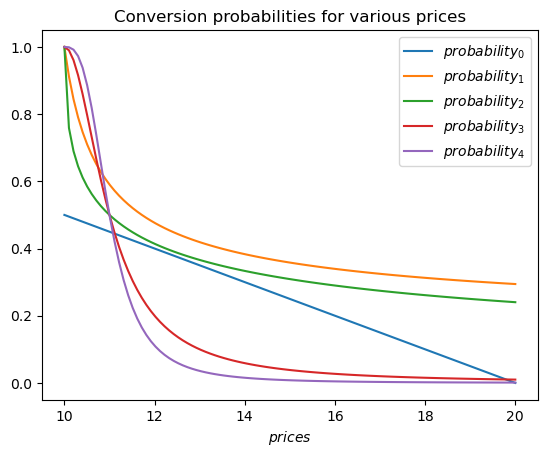

In [120]:
conv_prob_per_price = []
for p in prices:
    prob_per_price = []
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        prob_per_price.append(conv_prob(p))
    conv_prob_per_price.append(prob_per_price)

plt.plot(prices, conv_prob_per_price, label=[f'$probability_{i}$' for i in range(len(conversion_probabilities))])
plt.title("Conversion probabilities for various prices")
plt.legend()
plt.xlabel('$prices$')
plt.show();

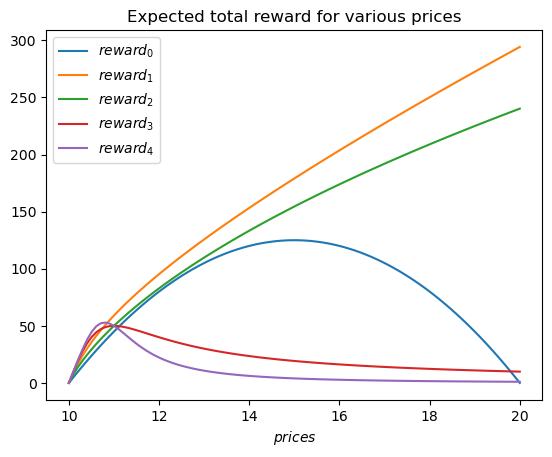

In [121]:
profit_curves_per_price = []
for p in prices:
    prob_per_price = []
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        prob_per_price.append(reward_function(p, cost, daily_customers * conv_prob(p)))
    profit_curves_per_price.append(prob_per_price)

plt.plot(prices, profit_curves_per_price, label=[f'$reward_{i}$' for i in range(len(conversion_probabilities))])
plt.title("Expected total reward for various prices")
plt.legend()
plt.xlabel('$prices$')
plt.show();

In [122]:
# let's compute the clairvoyant
# Each interval has a different conversion probability function and i calculate the best price for each interval
# The clayrvoiant will choose the best price for each interval and will sell to all the customers in the interval
best_prices = np.array([])
expected_clairvoyant_rewards = np.array([])
for t in range(T):
    conv_prob = mu[t]
    daily_profit_curve = reward_function(prices, cost, daily_customers * conv_prob(prices))
    best_price_index = np.argmax(daily_profit_curve)
    best_price = prices[best_price_index]
    best_prices = np.append(best_prices, best_price)
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_profit_curve[best_price_index])


100%|██████████| 10000/10000 [00:00<00:00, 90018.89it/s]


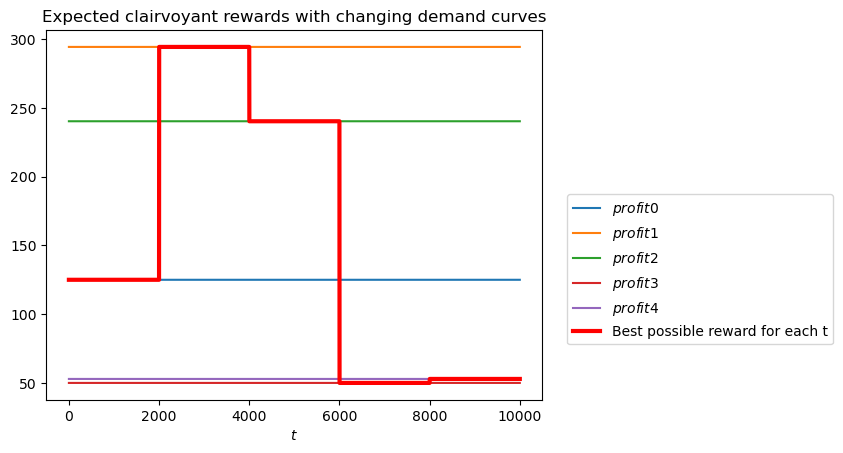

In [123]:
profits = []
for i in range(len(conversion_probabilities)):
    profit_per_prob = np.array([])
    conv_prob = conversion_probabilities[i]
    for t in tqdm(range(T)):
        daily_profit_curve = reward_function(prices, cost, daily_customers * conv_prob(prices))
        best_price_index = np.argmax(daily_profit_curve)
        profit_per_prob = np.append(profit_per_prob, daily_profit_curve[best_price_index])
    profits.append(profit_per_prob)

t = np.arange(T)
for i in range(len(conversion_probabilities)):
    plt.plot(t, profits[i], label=f'$profit{i}$')
plt.plot(t, expected_clairvoyant_rewards, label='Best possible reward for each t', linewidth=3, color='red')
plt.title("Expected clairvoyant rewards with changing demand curves")
plt.legend(loc=(1.05,0.15))
plt.xlabel('$t$')
plt.show();

### Sliding Window UCB1

In [ ]:
K = len(prices) # number of arms
U = len(conversion_probabilities) # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U)) # assuming U_T is known
W = 2000
print(f'K={K}, U={U}, W={W}')

n_trials = 15

mu = [[conversion_probabilities[i]]*(T//len(conversion_probabilities)) for i in range(len(conversion_probabilities))]
mu = np.array(mu).flatten()

regret_per_trial = []

for seed in tqdm(range(n_trials)):

    np.random.seed(seed)

    env = NonStationaryPricingEnv(mu, cost)
    ucb_agent = SWUCBAgent(K, T, W, range=max(expected_clairvoyant_rewards))

    agent_rewards = np.array([])
    chosen_prices = np.array([])
    for t in tqdm(range(T)):
        i = ucb_agent.pull_arm()
        p_t = prices[i]
        chosen_prices = np.append(chosen_prices, p_t)
        d_t, r_t = env.round(p_t, daily_customers, t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

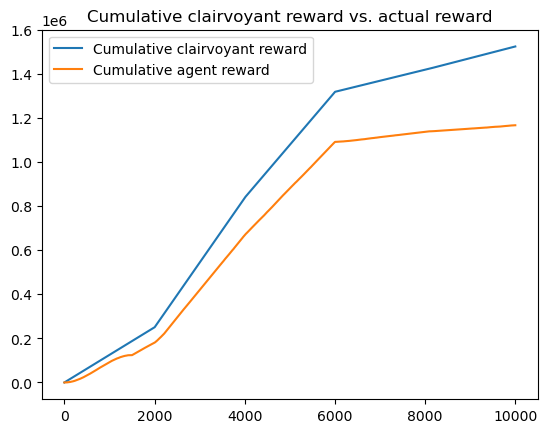

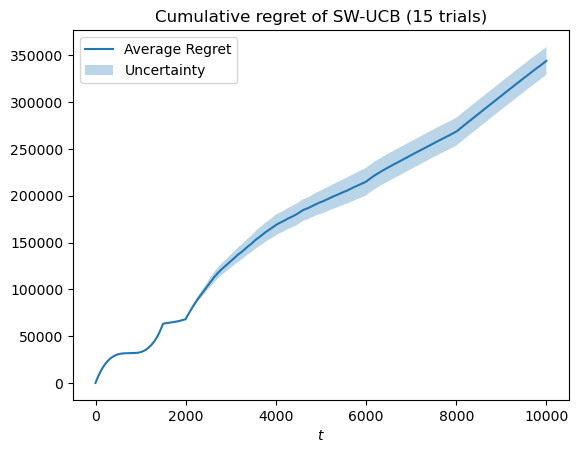

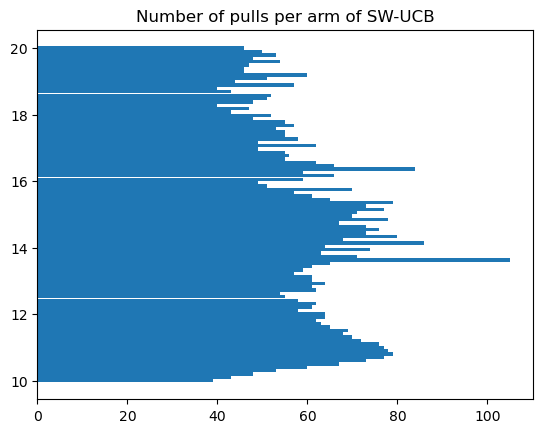

In [132]:
plt.plot(np.arange(T), np.cumsum(expected_clairvoyant_rewards), label='Cumulative clairvoyant reward')
plt.plot(np.arange(T), np.cumsum(agent_rewards), label='Cumulative agent reward')
plt.title("Cumulative clairvoyant reward vs. actual reward")
plt.legend()
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of SW-UCB (15 trials)')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=ucb_agent.N_pulls, height=0.1)
plt.title('Number of pulls per arm of SW-UCB')
plt.show();

### CUSUM

In [134]:
K = len(prices)
U = len(conversion_probabilities) # maximum number of abrupt changes
h = 5*max(expected_clairvoyant_rewards)*np.log(T/U) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U*np.log(T/U)/T) # probability of extra exploration
M = int(2*np.log(T/U)) # robustness of change detection

n_trials = 15

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonStationaryPricingEnv(mu, cost)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha, range=max(expected_clairvoyant_rewards))

    agent_rewards = np.array([])

    for t in tqdm(range(T)):
        a_t = ucb_agent.pull_arm()
        p_t = prices[a_t]
        d_t, r_t = env.round(p_t, daily_customers, t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

 25%|██▍       | 2470/10000 [00:00<00:00, 24683.43it/s]

Change detected on arm 57 at time 2145
Change detected on arm 98 at time 2685
Change detected on arm 98 at time 3055


 49%|████▉     | 4939/10000 [00:00<00:00, 7525.28it/s] 

Change detected on arm 98 at time 4233
Change detected on arm 87 at time 4311
Change detected on arm 88 at time 4389
Change detected on arm 95 at time 4455
Change detected on arm 93 at time 4526
Change detected on arm 83 at time 4615
Change detected on arm 95 at time 5348


100%|██████████| 10000/10000 [00:01<00:00, 9853.32it/s]


Change detected on arm 83 at time 6095
Change detected on arm 57 at time 6282


 25%|██▌       | 2537/10000 [00:00<00:00, 25324.14it/s]

Change detected on arm 54 at time 2172
Change detected on arm 70 at time 2644
Change detected on arm 76 at time 2793
Change detected on arm 87 at time 2863
Change detected on arm 87 at time 4308

 51%|█████     | 5070/10000 [00:00<00:00, 6174.35it/s] 


Change detected on arm 97 at time 4368
Change detected on arm 86 at time 4456
Change detected on arm 72 at time 4590
Change detected on arm 84 at time 4674
Change detected on arm 97 at time 5974

100%|██████████| 10000/10000 [00:01<00:00, 7611.27it/s]



Change detected on arm 54 at time 6516
Change detected on arm 87 at time 9966


 25%|██▌       | 2533/10000 [00:00<00:00, 25282.71it/s]

Change detected on arm 57 at time 2167
Change detected on arm 84 at time 2664
Change detected on arm 84 at time 4172

 51%|█████     | 5062/10000 [00:00<00:00, 5776.53it/s] 


Change detected on arm 76 at time 4281
Change detected on arm 96 at time 4348
Change detected on arm 97 at time 4417
Change detected on arm 93 at time 4487
Change detected on arm 95 at time 4559
Change detected on arm 86 at time 4640
Change detected on arm 93 at time 5284
Change detected on arm 91 at time 5355
Change detected on arm 94 at time 5419
Change detected on arm 89 at time 5497
Change detected on arm 99 at time 5561
Change detected on arm 78 at time 5664
Change detected on arm 78 at time 6103


100%|██████████| 10000/10000 [00:01<00:00, 9244.90it/s]


Change detected on arm 57 at time 6322


  0%|          | 0/10000 [00:00<?, ?it/s]

Change detected on arm 96 at time 2042


 60%|██████    | 6045/10000 [00:01<00:01, 3385.47it/s] 

Change detected on arm 96 at time 4037
Change detected on arm 90 at time 4117
Change detected on arm 87 at time 4199
Change detected on arm 89 at time 4276
Change detected on arm 83 at time 4372
Change detected on arm 84 at time 4457
Change detected on arm 71 at time 4595
Change detected on arm 92 at time 4664
Change detected on arm 88 at time 4744
Change detected on arm 96 at time 6042


 25%|██▍       | 2472/10000 [00:00<00:00, 24689.12it/s]

Change detected on arm 90 at time 2054
Change detected on arm 90 at time 3934


 49%|████▉     | 4941/10000 [00:00<00:01, 4387.31it/s] 

Change detected on arm 97 at time 3988
Change detected on arm 76 at time 4100
Change detected on arm 78 at time 4207
Change detected on arm 97 at time 4478
Change detected on arm 81 at time 4581
Change detected on arm 99 at time 4641
Change detected on arm 72 at time 4770
Change detected on arm 95 at time 4835
Change detected on arm 88 at time 4917
Change detected on arm 93 at time 4985


100%|██████████| 10000/10000 [00:01<00:00, 6991.04it/s]


Change detected on arm 97 at time 6033


  0%|          | 0/10000 [00:00<?, ?it/s]

Change detected on arm 64 at time 2120


 25%|██▌       | 2524/10000 [00:00<00:00, 25212.49it/s]

Change detected on arm 96 at time 3232
Change detected on arm 94 at time 3416
Change detected on arm 76 at time 3603
Change detected on arm 96 at time 4317


 50%|█████     | 5046/10000 [00:00<00:00, 6651.72it/s] 

Change detected on arm 78 at time 4426
Change detected on arm 75 at time 4555
Change detected on arm 94 at time 4818
Change detected on arm 84 at time 4920
Change detected on arm 95 at time 4991
Change detected on arm 99 at time 5427
Change detected on arm 85 at time 5556
Change detected on arm 79 at time 5713
Change detected on arm 95 at time 6093
Change detected on arm 64 at time 6197


100%|██████████| 10000/10000 [00:00<00:00, 10010.82it/s]


Change detected on arm 78 at time 6299


 26%|██▌       | 2617/10000 [00:00<00:00, 26151.69it/s]

Change detected on arm 59 at time 2163
Change detected on arm 71 at time 2270
Change detected on arm 71 at time 4001
Change detected on arm 96 at time 4069


 52%|█████▏    | 5233/10000 [00:00<00:01, 4717.25it/s] 

Change detected on arm 87 at time 4152
Change detected on arm 79 at time 4259
Change detected on arm 90 at time 4337
Change detected on arm 72 at time 4464
Change detected on arm 74 at time 4584
Change detected on arm 94 at time 4651
Change detected on arm 99 at time 5283
Change detected on arm 85 at time 5401
Change detected on arm 96 at time 6038

100%|██████████| 10000/10000 [00:01<00:00, 7784.38it/s]



Change detected on arm 79 at time 6198


 25%|██▌       | 2506/10000 [00:00<00:00, 25011.72it/s]

Change detected on arm 66 at time 2121
Change detected on arm 84 at time 3197
Change detected on arm 75 at time 3325
Change detected on arm 87 at time 3608


 50%|█████     | 5008/10000 [00:00<00:00, 5909.61it/s] 

Change detected on arm 75 at time 4376
Change detected on arm 84 at time 4627
Change detected on arm 93 at time 4699
Change detected on arm 70 at time 4872
Change detected on arm 86 at time 4970
Change detected on arm 87 at time 5206
Change detected on arm 71 at time 5339
Change detected on arm 82 at time 5486


100%|██████████| 10000/10000 [00:01<00:00, 9030.94it/s]


Change detected on arm 66 at time 6062
Change detected on arm 75 at time 6184


 27%|██▋       | 2668/10000 [00:00<00:00, 26651.50it/s]

Change detected on arm 80 at time 2336
Change detected on arm 80 at time 4103


 53%|█████▎    | 5334/10000 [00:00<00:00, 4975.30it/s] 

Change detected on arm 96 at time 4168
Change detected on arm 69 at time 4298
Change detected on arm 74 at time 4406
Change detected on arm 73 at time 4524
Change detected on arm 82 at time 4623
Change detected on arm 78 at time 4730
Change detected on arm 77 at time 4841
Change detected on arm 83 at time 4948
Change detected on arm 88 at time 5026
Change detected on arm 86 at time 5110
Change detected on arm 71 at time 5260
Change detected on arm 82 at time 6124


100%|██████████| 10000/10000 [00:01<00:00, 7889.31it/s]


Change detected on arm 86 at time 7078
Change detected on arm 50 at time 8689


 26%|██▌       | 2616/10000 [00:00<00:00, 26147.43it/s]

Change detected on arm 58 at time 2190
Change detected on arm 82 at time 2273
Change detected on arm 82 at time 4315


 52%|█████▏    | 5231/10000 [00:01<00:01, 3734.24it/s] 

Change detected on arm 81 at time 4421
Change detected on arm 96 at time 4483
Change detected on arm 86 at time 4576
Change detected on arm 87 at time 4664


100%|██████████| 10000/10000 [00:01<00:00, 6254.79it/s]


Change detected on arm 86 at time 6125
Change detected on arm 82 at time 6175


  0%|          | 0/10000 [00:00<?, ?it/s]

Change detected on arm 92 at time 2058


 50%|████▉     | 4961/10000 [00:01<00:01, 3360.12it/s] 

Change detected on arm 92 at time 4256
Change detected on arm 77 at time 4367
Change detected on arm 93 at time 4440
Change detected on arm 96 at time 4503
Change detected on arm 75 at time 4632
Change detected on arm 90 at time 4707
Change detected on arm 81 at time 4921
Change detected on arm 70 at time 4961
Change detected on arm 82 at time 5054
Change detected on arm 96 at time 6016


 26%|██▌       | 2564/10000 [00:00<00:00, 25611.33it/s]

Change detected on arm 60 at time 2124
Change detected on arm 95 at time 2191
Change detected on arm 95 at time 4129


 51%|█████▏    | 5126/10000 [00:01<00:01, 3711.88it/s] 

Change detected on arm 97 at time 4190
Change detected on arm 76 at time 4296
Change detected on arm 95 at time 6034


 25%|██▌       | 2505/10000 [00:00<00:00, 25035.52it/s]

Change detected on arm 81 at time 2081


 50%|█████     | 5009/10000 [00:01<00:01, 3334.73it/s] 

Change detected on arm 81 at time 4318
Change detected on arm 77 at time 4416
Change detected on arm 79 at time 4532
Change detected on arm 83 at time 4623
Change detected on arm 70 at time 4765
Change detected on arm 86 at time 4853
Change detected on arm 76 at time 5674
Change detected on arm 73 at time 5816


100%|██████████| 10000/10000 [00:01<00:00, 5799.42it/s]


Change detected on arm 83 at time 6108


  0%|          | 0/10000 [00:00<?, ?it/s]

Change detected on arm 52 at time 2215
Change detected on arm 93 at time 2276


 26%|██▌       | 2605/10000 [00:00<00:00, 26004.21it/s]

Change detected on arm 93 at time 4035
Change detected on arm 75 at time 4158
Change detected on arm 79 at time 4263


 64%|██████▍   | 6431/10000 [00:01<00:00, 5078.92it/s] 

Change detected on arm 93 at time 5140
Change detected on arm 97 at time 5201
Change detected on arm 89 at time 5283
Change detected on arm 99 at time 5343
Change detected on arm 84 at time 5433
Change detected on arm 95 at time 5499
Change detected on arm 97 at time 6060


 25%|██▌       | 2536/10000 [00:00<00:00, 25336.41it/s]

Change detected on arm 58 at time 2146
Change detected on arm 92 at time 2614


 51%|█████     | 5070/10000 [00:00<00:00, 5490.60it/s] 

Change detected on arm 92 at time 4263
Change detected on arm 99 at time 4326
Change detected on arm 93 at time 4394
Change detected on arm 95 at time 4463
Change detected on arm 84 at time 4565
Change detected on arm 85 at time 4656
Change detected on arm 81 at time 4755
Change detected on arm 88 at time 5393
Change detected on arm 99 at time 6037
Change detected on arm 85 at time 6126


100%|██████████| 10000/10000 [00:01<00:00, 8239.55it/s]

Change detected on arm 58 at time 6442


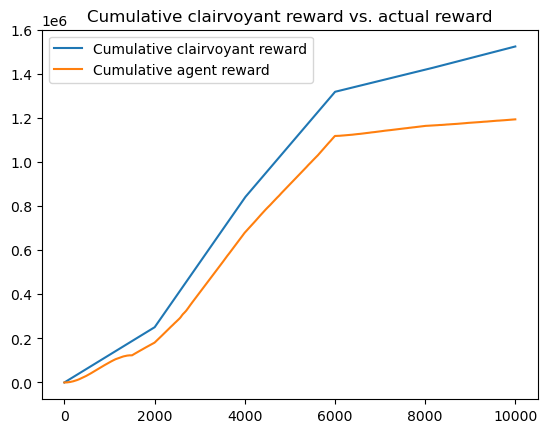

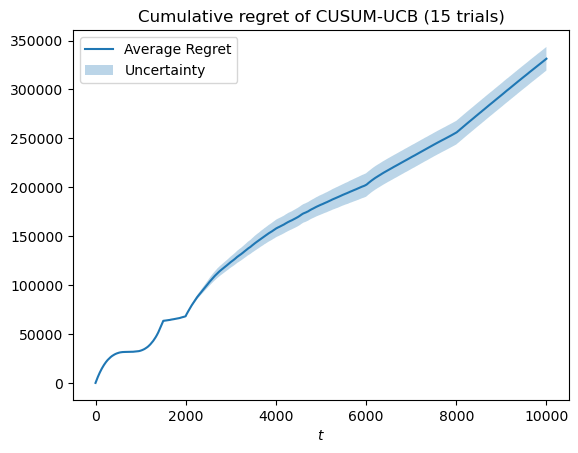

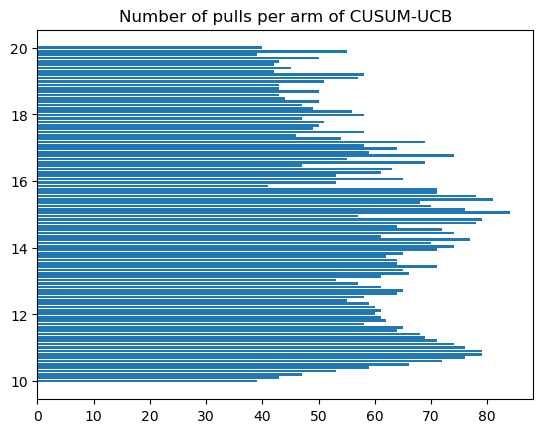

In [136]:
plt.plot(np.arange(T), np.cumsum(expected_clairvoyant_rewards), label='Cumulative clairvoyant reward')
plt.plot(np.arange(T), np.cumsum(agent_rewards), label='Cumulative agent reward')
plt.title("Cumulative clairvoyant reward vs. actual reward")
plt.legend()
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of CUSUM-UCB (15 trials)')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=ucb_agent.N_pulls, height=0.08)
plt.title('Number of pulls per arm of CUSUM-UCB')
plt.show();

## Multiple products

In [140]:
# Utility function
def rescale(x, min_x, max_x):
    assert type(x) == np.ndarray or type(x) == list
    return [min_x + (max_x-min_x)*x_i for x_i in x]

In [141]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class MultiAgentGPUCBLearner():
    def __init__(self, T, discretization_1=100, discretization_2=100):
        self.T = T
        self.arms = np.array([
            np.linspace(0, 1, discretization_1),
            np.linspace(0, 1, discretization_2)
        ])
        assert len(self.arms) == 2
        kernel = RBF(1.0, (1e-3, 1e3))
        alpha = 1
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha ** 2, normalize_y=True, n_restarts_optimizer=9)
        self.a_t = None
        self.action_hist = [[], []]
        self.reward_hist = [[], []]
        
        self.confidence = [
            [np.inf] * discretization_1,
            [np.inf] * discretization_2
        ]
        self.empirical_means = [
            np.zeros(discretization_1),
            np.zeros(discretization_2)
        ]
        self.sigmas = [
            np.ones(discretization_1),
            np.ones(discretization_2)
        ]

    def pull_arm(self):
        upper_confidence_bound = [
            self.empirical_means[0] + self.sigmas[0],
            self.empirical_means[1] + self.sigmas[1]
        ]
        # Return where the confidence is maximum, for each of the two agents
        self.a_t = [
            np.argmax(upper_confidence_bound[0]),
            np.argmax(upper_confidence_bound[1])
        ]
        return [
            self.arms[0][self.a_t[0]],
            self.arms[1][self.a_t[1]]
        ]
    
    def update(self, r_t):
        self.action_hist[0].append(self.arms[0][self.a_t[0]])
        self.action_hist[1].append(self.arms[1][self.a_t[1]])
        self.reward_hist[0].append(r_t[0])
        self.reward_hist[1].append(r_t[1])
        
        self.gp.fit(np.array(self.action_hist).T, np.array(self.reward_hist).T)
        
        # for i in range(2):
        #     print(np.atleast_2d(self.arms[i]).T)
        #     self.empirical_means[i], self.sigmas[i] = self.gp.predict(np.atleast_2d(self.arms[i]).T, return_std=True)
        #     self.sigmas[i] = np.maximum(self.sigmas[i], 1e-2)
        self.empirical_means, self.sigmas = self.gp.predict(np.atleast_2d(np.array(self.arms)).T, return_std=True)

In [142]:
class MultiProductPricingEnvironment:
    def __init__(self, conversion_probability, costs):
        self.conversion_probability = conversion_probability
        self.costs = costs

    def round(self, p_t, n_t):
        assert type(p_t) == np.ndarray or type(p_t) == list
        assert len(p_t) == 2
        d_t = [np.random.binomial(n_t, self.conversion_probability[i](p_t[0], p_t[1])) for i in range(2)]
        r_t = [(p_t[i] - self.costs[i])*d_t[i] for i in range(2)]
        return d_t, r_t

In [143]:
# Parameters definition
max_price_1, min_price_1 = 50, 10
max_price_2, min_price_2 = 50, 20
min_price, max_price = min(min_price_1, min_price_2), max(max_price_1, max_price_2)
costs = [min_price_1, min_price_2]

T = 365
daily_customers = 100
K = 100 # discretization intervals

conversion_probabilities = [
    lambda p1, p2: 1-p1/max_price,  # linear demand curve
    lambda p1, p2: (p1/max_price)*(1-p2/max_price)
]

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 1000 different prices between 10 and 20

# let's compute the clairvoyant: it is the repetition for T times of the maximum daily profit
expected_clairvoyant_rewards = np.array([])
for t in range(T):
    daily_rewards = np.array([])
    best_prices = np.array([])
    for i in range(len(conversion_probabilities)):
        conv_prob = conversion_probabilities[i]
        daily_profit_curve = reward_function(prices, costs[i], daily_customers * conv_prob(prices, prices))
        best_price_index = np.argmax(daily_profit_curve)
        best_prices = np.append(best_prices, prices[best_price_index])
        daily_rewards = np.append(daily_rewards, daily_profit_curve[best_price_index])
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_rewards.sum())

In [144]:
from tqdm import tqdm

# Interaction between agent and environment
env = MultiProductPricingEnvironment(conversion_probabilities, costs)
agent = MultiAgentGPUCBLearner(T, discretization_1=K, discretization_2=K)

rewards = np.array([])
for t in tqdm(range(T)):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price) # p_t is a vector of 2 components (price for product 1 and price for product 2)
    d_t, r_t = env.round(p_t, n_t=daily_customers)
    agent.update([r_t[0] / daily_customers, r_t[1] / daily_customers])
    rewards = np.append(rewards, np.array(r_t).sum())

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-rewards)

100%|██████████| 365/365 [00:08<00:00, 43.04it/s] 


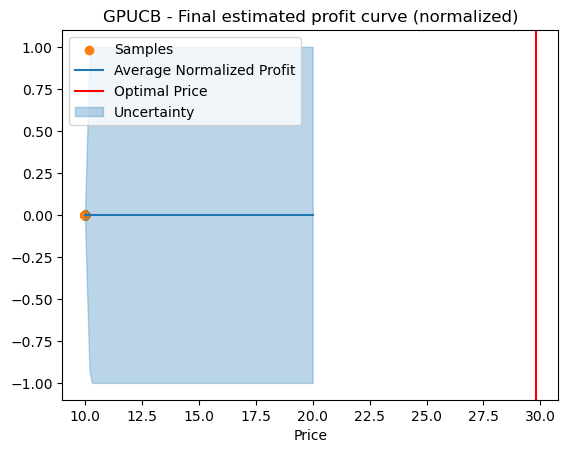

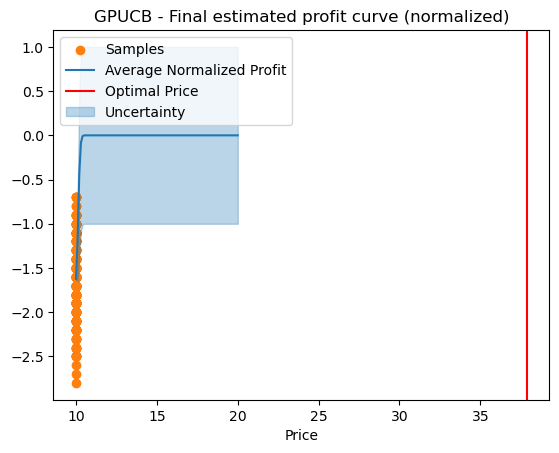

In [145]:
for i in range(2):
    prices = rescale(agent.action_hist[i], min_price, max_price)
    profits = agent.reward_hist[i]
    gp = RBFGaussianProcess(scale=2)
    gp.fit(prices, profits)
    mu, sigma = gp.predict(np.linspace(min_price, max_price, K))
    plt.scatter(prices, profits, label='Samples', color='C1')
    plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
    plt.axvline(best_prices[i], color='red',label='Optimal Price')
    plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
    plt.title('GPUCB - Final estimated profit curve (normalized)')
    plt.xlabel('Price')
    plt.legend()
    plt.show();

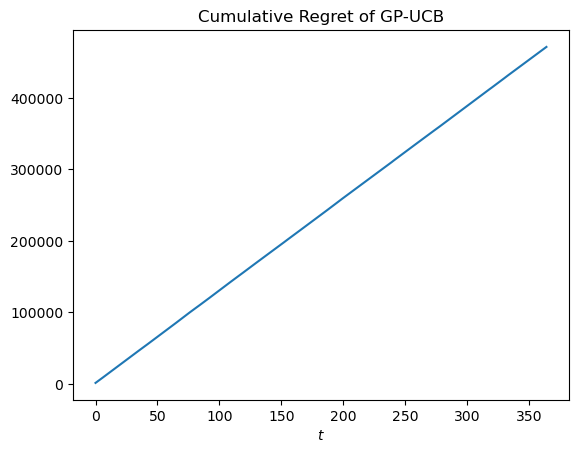

In [146]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();